In [1]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda
from tensorflow.keras.models import Model
import pickle
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping
import pandas as pd
import warnings

## Load forecast dataset into matrices.

In [6]:
pred_window = 2 # hours
obs_windows = range(20, 124, 4)

# Read data.
data_path = 'mimic_iv_preprocessed.pkl'
data, oc, train_ind, valid_ind, test_ind = pickle.load(open(data_path, 'rb'))
data.fillna(0, inplace=True) 
# Remove test patients.
data = data.merge(oc[['ts_ind', 'subject_id']], on='ts_ind', how='left')
test_sub = oc.loc[oc.ts_ind.isin(test_ind)].subject_id.unique()
data = data.loc[~data.subject_id.isin(test_sub)]
oc = oc.loc[~oc.subject_id.isin(test_sub)]
data.drop(columns=['subject_id', 'TABLE'], inplace=True)
# Fix age.
data.loc[(data.variable=='age')&(data.value>200), 'value'] = 91.4
# Get static data with mean fill and missingness indicator.
static_varis = ['age', 'gender']
ii = data.variable.isin(static_varis)
static_data = data.loc[ii]
data = data.loc[~ii]
def inv_list(l, start=0):
    d = {}
    for i in range(len(l)):
        d[l[i]] = i+start
    return d
static_var_to_ind = inv_list(static_varis)
D = len(static_varis)
N = data.ts_ind.max()+1
demo = np.zeros((N, D))
for row in tqdm(static_data.itertuples()):
    demo[row.ts_ind, static_var_to_ind[row.variable]] = row.value
# Normalize static data.
means = demo.mean(axis=0, keepdims=True)
stds = demo.std(axis=0, keepdims=True)
stds = (stds==0)*1 + (stds!=0)*stds
demo = (demo-means)/stds
# Get variable indices.
varis = sorted(list(set(data.variable)))
V = len(varis)
var_to_ind = inv_list(varis, start=1)
data['vind'] = data.variable.map(var_to_ind)
data = data[['ts_ind', 'vind', 'hour', 'value']].sort_values(by=['ts_ind', 'vind', 'hour'])
# Find max_len.
fore_max_len = 880
# Get forecast inputs and outputs.
fore_times_ip = []
fore_values_ip = []
fore_varis_ip = []
fore_op = []
fore_inds = []
def f(x):
    mask = [0 for i in range(V)]
    values = [0 for i in range(V)]
    for vv in x:
        v = int(vv[0])-1
        mask[v] = 1
        values[v] = vv[1]
    return values+mask
def pad(x):
    return x+[0]*(fore_max_len-len(x))
for w in tqdm(obs_windows):
    pred_data = data.loc[(data.hour>=w)&(data.hour<=w+pred_window)]
    pred_data = pred_data.groupby(['ts_ind', 'vind']).agg({'value':'first'}).reset_index()
    pred_data['vind_value'] = pred_data[['vind', 'value']].values.tolist()
    pred_data = pred_data.groupby('ts_ind').agg({'vind_value':list}).reset_index()
    pred_data['vind_value'] = pred_data['vind_value'].apply(f)    
    obs_data = data.loc[(data.hour<w)&(data.hour>=w-24)]
    obs_data = obs_data.loc[obs_data.ts_ind.isin(pred_data.ts_ind)]
    obs_data = obs_data.groupby('ts_ind').head(fore_max_len)
    obs_data = obs_data.groupby('ts_ind').agg({'vind':list, 'hour':list, 'value':list}).reset_index()
    obs_data = obs_data.merge(pred_data, on='ts_ind')
    for col in ['vind', 'hour', 'value']:
        obs_data[col] = obs_data[col].apply(pad)
    fore_op.append(np.array(list(obs_data.vind_value)))
    fore_inds.append(np.array(list(obs_data.ts_ind)))
    fore_times_ip.append(np.array(list(obs_data.hour)))
    fore_values_ip.append(np.array(list(obs_data.value)))
    fore_varis_ip.append(np.array(list(obs_data.vind)))
del data
fore_times_ip = np.concatenate(fore_times_ip, axis=0)
fore_values_ip = np.concatenate(fore_values_ip, axis=0)
fore_varis_ip = np.concatenate(fore_varis_ip, axis=0)
fore_op = np.concatenate(fore_op, axis=0)
fore_inds = np.concatenate(fore_inds, axis=0)
fore_demo = demo[fore_inds]
# Get train and valid ts_ind for forecast task.
train_sub = oc.loc[oc.ts_ind.isin(train_ind)].subject_id.unique()
valid_sub = oc.loc[oc.ts_ind.isin(valid_ind)].subject_id.unique()
rem_sub = oc.loc[~oc.subject_id.isin(np.concatenate((train_ind, valid_ind)))].subject_id.unique()
bp = int(0.8*len(rem_sub))
train_sub = np.concatenate((train_sub, rem_sub[:bp]))
valid_sub = np.concatenate((valid_sub, rem_sub[bp:]))
train_ind = oc.loc[oc.subject_id.isin(train_sub)].ts_ind.unique() # Add remaining ts_ind s of train subjects.
valid_ind = oc.loc[oc.subject_id.isin(valid_sub)].ts_ind.unique() # Add remaining ts_ind s of train subjects.
# Generate 3 sets of inputs and outputs.
train_ind = np.argwhere(np.in1d(fore_inds, train_ind)).flatten()
valid_ind = np.argwhere(np.in1d(fore_inds, valid_ind)).flatten()
fore_train_ip = [ip[train_ind] for ip in [fore_demo, fore_times_ip, fore_values_ip, fore_varis_ip]]
fore_valid_ip = [ip[valid_ind] for ip in [fore_demo, fore_times_ip, fore_values_ip, fore_varis_ip]]
del fore_times_ip, fore_values_ip, fore_varis_ip, demo, fore_demo
fore_train_op = fore_op[train_ind]
fore_valid_op = fore_op[valid_ind]
del fore_op

95780it [00:00, 847375.25it/s]
100%|██████████| 26/26 [03:34<00:00,  8.24s/it]


In [4]:
len(rem_sub), fore_train_ip[1].shape, fore_valid_ip[0].shape

(34961, (444837, 880), (169128, 2))

In [3]:
# m = data.groupby('ts_ind').agg({'hour':'max'}).hour
# for q in [0.5,0.6,0.7,0.8,0.9, 0.95, 0.99, 1]:
#     print (q, m.quantile(q))
# import matplotlib.pyplot as plt
# plt.plot(sorted(list(m)))

## Load target dataset into matrices.

In [8]:
# Read data.
data_path = 'mimic_iv_preprocessed.pkl'
data, oc, train_ind, valid_ind, test_ind = pickle.load(open(data_path, 'rb'))
data.fillna(0, inplace=True) 
print(len(train_ind),len(valid_ind),len(test_ind))
# Filter labeled data in first 24h.
data = data.loc[data.ts_ind.isin(np.concatenate((train_ind, valid_ind, test_ind), axis=-1))]
data = data.loc[(data.hour>=0)&(data.hour<=24)]
oc = oc.loc[oc.ts_ind.isin(np.concatenate((train_ind, valid_ind, test_ind), axis=-1))]
# Fix age.
data.loc[(data.variable=='age')&(data.value>200), 'value'] = 91.4
# Get y and N.
y = np.array(oc.sort_values(by='ts_ind')['in_hospital_mortality']).astype('float32')

N = data.ts_ind.max() + 1
# Get static data with mean fill and missingness indicator.
static_varis = ['age', 'gender']
ii = data.variable.isin(static_varis)
static_data = data.loc[ii]
data = data.loc[~ii]
def inv_list(l, start=0):
    d = {}
    for i in range(len(l)):
        d[l[i]] = i+start
    return d
static_var_to_ind = inv_list(static_varis)
D = len(static_varis)
demo = np.zeros((N, D))
for row in tqdm(static_data.itertuples()):
    demo[row.ts_ind, static_var_to_ind[row.variable]] = row.value
# Normalize static data.
means = demo.mean(axis=0, keepdims=True)
stds = demo.std(axis=0, keepdims=True)
stds = (stds==0)*1 + (stds!=0)*stds
demo = (demo-means)/stds
# Trim to max len.
data = data.sample(frac=1)
data = data.groupby('ts_ind').head(880)
# Get N, V, var_to_ind.
N = data.ts_ind.max() + 1
varis = sorted(list(set(data.variable)))
V = len(varis)
def inv_list(l, start=0):
    d = {}
    for i in range(len(l)):
        d[l[i]] = i+start
    return d
var_to_ind = inv_list(varis, start=1)
data['vind'] = data.variable.map(var_to_ind)
data = data[['ts_ind', 'vind', 'hour', 'value']].sort_values(by=['ts_ind', 'vind', 'hour'])
# Add obs index.
data = data.sort_values(by=['ts_ind']).reset_index(drop=True)
data = data.reset_index().rename(columns={'index':'obs_ind'})
data = data.merge(data.groupby('ts_ind').agg({'obs_ind':'min'}).reset_index().rename(columns={ \
                                                            'obs_ind':'first_obs_ind'}), on='ts_ind')
data['obs_ind'] = data['obs_ind'] - data['first_obs_ind']
# Find max_len.
max_len = data.obs_ind.max()+1
print ('max_len', max_len)
# Generate times_ip and values_ip matrices.
times_inp = np.zeros((N, max_len), dtype='float32')
values_inp = np.zeros((N, max_len), dtype='float32')
varis_inp = np.zeros((N, max_len), dtype='int32')
for row in tqdm(data.itertuples()):
    ts_ind = row.ts_ind
    l = row.obs_ind
    times_inp[ts_ind, l] = row.hour
    values_inp[ts_ind, l] = row.value
    varis_inp[ts_ind, l] = row.vind
data.drop(columns=['obs_ind', 'first_obs_ind'], inplace=True)
# Generate 3 sets of inputs and outputs.
train_ip = [ip[train_ind] for ip in [demo, times_inp, values_inp, varis_inp]]
valid_ip = [ip[valid_ind] for ip in [demo, times_inp, values_inp, varis_inp]]
test_ip = [ip[test_ind] for ip in [demo, times_inp, values_inp, varis_inp]]
del times_inp, values_inp, varis_inp
train_op = y[train_ind]
valid_op = y[valid_ind]
test_op = y[test_ind]

train_op_ind_df = pd.DataFrame({
    'train_ind': train_ind,
    'train_op': y[train_ind]
})

# For Valid Data
valid_op_ind_df = pd.DataFrame({
    'valid_ind': valid_ind,
    'valid_op': y[valid_ind]
})

# For Test Data
test__op_ind_df = pd.DataFrame({
    'test_ind': test_ind,
    'test_op': y[test_ind]
})

#print(valid_op)
print(len(train_op))

print(len(valid_op))

print(len(test_op))
#print(test_ip)
#print(test_ip.shape,test_op.shape)
del y

29172 7222 9172


91132it [00:00, 661295.33it/s]


max_len 880


18653168it [00:27, 668403.66it/s]


29172
7222
9172


In [6]:
y = np.concatenate((train_op,valid_op,test_op))
print(len(y))
y.sum()/len(y)
len(y)

45566


45566

In [7]:
# l = data.groupby('ts_ind').size()
# print (sorted(l)[-500:], l.quantile(0.99), len(l))

## Define metrics and losses.

In [4]:
#def get_res(y_true, y_pred):
    #if len(set(y_true)) > 1:
        #return roc_auc_score(y_true, y_pred)
    #else:
        #print("Warning: ROC AUC score is undefined for single class validation set.")
        #return None





def get_res(y_true, y_pred):
    #df = pd.DataFrame({
    #'y_true': y_true,
    #'y_pred': y_pred
#})

# Save DataFrame to CSV
    #df.to_csv('y_true_y_pred.csv', index=False)
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    
    #if len(set(y_true)) > 1:
    pr_auc = auc(recall, precision)
    minrp = np.minimum(precision, recall).max()
    roc_auc = roc_auc_score(y_true, y_pred)
    return [roc_auc, pr_auc, minrp]
    #else:
        #print("Warning: ROC AUC score is undefined for single class validation set.")
        #return None
    
class_weights = compute_class_weight(class_weight='balanced', classes=[0,1], y=train_op)
def mortality_loss(y_true, y_pred):
    sample_weights = (1-y_true)*class_weights[0] + y_true*class_weights[1]
    bce = K.binary_crossentropy(y_true, y_pred)
    return K.mean(sample_weights*bce, axis=-1)

# var_weights = np.sum(fore_train_op[:, V:], axis=0)
# var_weights[var_weights==0] = var_weights.max()
# var_weights = var_weights.max()/var_weights
# var_weights = var_weights.reshape((1, V))
def forecast_loss(y_true, y_pred):
    return K.sum(y_true[:,V:]*(y_true[:,:V]-y_pred)**2, axis=-1)

def get_min_loss(weight):
    def min_loss(y_true, y_pred):
        return weight*y_pred
    return min_loss

class CustomCallback(Callback):
    def __init__(self, validation_data, batch_size):
        self.val_x, self.val_y = validation_data
        self.batch_size = batch_size
        super(Callback, self).__init__()

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.val_x, verbose=0, batch_size=self.batch_size)
        if type(y_pred)==type([]):
            y_pred = y_pred[0]
        precision, recall, thresholds = precision_recall_curve(self.val_y, y_pred)
        pr_auc = auc(recall, precision)
        roc_auc = roc_auc_score(self.val_y, y_pred)
        logs['custom_metric'] = pr_auc + roc_auc
        print ('val_aucs:', pr_auc, roc_auc)

## Define model architecture.

In [5]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Embedding, Activation, Dropout, Softmax, Layer, InputSpec, Input, Dense, Lambda, TimeDistributed, Concatenate, Add
from tensorflow.keras import initializers, regularizers, constraints, Model
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow import nn

    
class CVE(Layer):
    def __init__(self, hid_units, output_dim):
        self.hid_units = hid_units
        self.output_dim = output_dim
        super(CVE, self).__init__()
        
    def build(self, input_shape): 
        self.W1 = self.add_weight(name='CVE_W1',
                            shape=(1, self.hid_units),
                            initializer='glorot_uniform',
                            trainable=True)
        self.b1 = self.add_weight(name='CVE_b1',
                            shape=(self.hid_units,),
                            initializer='zeros',
                            trainable=True)
        self.W2 = self.add_weight(name='CVE_W2',
                            shape=(self.hid_units, self.output_dim),
                            initializer='glorot_uniform',
                            trainable=True)
        super(CVE, self).build(input_shape)
        
    def call(self, x):
        x = K.expand_dims(x, axis=-1)
        x = K.dot(K.tanh(K.bias_add(K.dot(x, self.W1), self.b1)), self.W2)
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape + (self.output_dim,)
    
    
class Attention(Layer):
    
    def __init__(self, hid_dim):
        self.hid_dim = hid_dim
        super(Attention, self).__init__()

    def build(self, input_shape):
        d = input_shape.as_list()[-1]
        self.W = self.add_weight(shape=(d, self.hid_dim), name='Att_W',
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.hid_dim,), name='Att_b',
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(self.hid_dim,1), name='Att_u',
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(Attention, self).build(input_shape)
        
    def call(self, x, mask, mask_value=-1e30):
        attn_weights = K.dot(K.tanh(K.bias_add(K.dot(x,self.W), self.b)), self.u)
        mask = K.expand_dims(mask, axis=-1)
        attn_weights = mask*attn_weights + (1-mask)*mask_value
        attn_weights = K.softmax(attn_weights, axis=-2)
        return attn_weights
        
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (1,)
    
    
class Transformer(Layer):
    
    def __init__(self, N=2, h=8, dk=None, dv=None, dff=None, dropout=0):
        self.N, self.h, self.dk, self.dv, self.dff, self.dropout = N, h, dk, dv, dff, dropout
        self.epsilon = K.epsilon() * K.epsilon()
        super(Transformer, self).__init__()

    def build(self, input_shape):
        d = input_shape.as_list()[-1]
        if self.dk==None:
            self.dk = d//self.h
        if self.dv==None:
            self.dv = d//self.h
        if self.dff==None:
            self.dff = 2*d
        self.Wq = self.add_weight(shape=(self.N, self.h, d, self.dk), name='Wq',
                                 initializer='glorot_uniform', trainable=True)
        self.Wk = self.add_weight(shape=(self.N, self.h, d, self.dk), name='Wk',
                                 initializer='glorot_uniform', trainable=True)
        self.Wv = self.add_weight(shape=(self.N, self.h, d, self.dv), name='Wv',
                                 initializer='glorot_uniform', trainable=True)
        self.Wo = self.add_weight(shape=(self.N, self.dv*self.h, d), name='Wo',
                                 initializer='glorot_uniform', trainable=True)
        self.W1 = self.add_weight(shape=(self.N, d, self.dff), name='W1',
                                 initializer='glorot_uniform', trainable=True)
        self.b1 = self.add_weight(shape=(self.N, self.dff), name='b1',
                                 initializer='zeros', trainable=True)
        self.W2 = self.add_weight(shape=(self.N, self.dff, d), name='W2',
                                 initializer='glorot_uniform', trainable=True)
        self.b2 = self.add_weight(shape=(self.N, d), name='b2',
                                 initializer='zeros', trainable=True)
        self.gamma = self.add_weight(shape=(2*self.N,), name='gamma',
                                 initializer='ones', trainable=True)
        self.beta = self.add_weight(shape=(2*self.N,), name='beta',
                                 initializer='zeros', trainable=True)
        super(Transformer, self).build(input_shape)
        
    def call(self, x, mask, mask_value=-1e-30):
        mask = K.expand_dims(mask, axis=-2)
        for i in range(self.N):
            # MHA
            mha_ops = []
            for j in range(self.h):
                q = K.dot(x, self.Wq[i,j,:,:])
                k = K.permute_dimensions(K.dot(x, self.Wk[i,j,:,:]), (0,2,1))
                v = K.dot(x, self.Wv[i,j,:,:])
                A = K.batch_dot(q,k)
                # Mask unobserved steps.
                A = mask*A + (1-mask)*mask_value
                # Mask for attention dropout.
                def dropped_A():
                    dp_mask = K.cast((K.random_uniform(shape=array_ops.shape(A))>=self.dropout), K.floatx())
                    return A*dp_mask + (1-dp_mask)*mask_value
                A = tf_utils.smart_cond(K.learning_phase(), dropped_A, lambda: array_ops.identity(A))
                A = K.softmax(A, axis=-1)
                mha_ops.append(K.batch_dot(A,v))
            conc = K.concatenate(mha_ops, axis=-1)
            proj = K.dot(conc, self.Wo[i,:,:])
            # Dropout.
            proj = tf_utils.smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(proj, rate=self.dropout)),\
                                       lambda: array_ops.identity(proj))
            # Add & LN
            x = x+proj
            mean = K.mean(x, axis=-1, keepdims=True)
            variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            x = (x - mean) / std
            x = x*self.gamma[2*i] + self.beta[2*i]
            # FFN
            ffn_op = K.bias_add(K.dot(K.relu(K.bias_add(K.dot(x, self.W1[i,:,:]), self.b1[i,:])), 
                           self.W2[i,:,:]), self.b2[i,:,])
            # Dropout.
            ffn_op = tf_utils.smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(ffn_op, rate=self.dropout)),\
                                       lambda: array_ops.identity(ffn_op))
            # Add & LN
            x = x+ffn_op
            mean = K.mean(x, axis=-1, keepdims=True)
            variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            x = (x - mean) / std
            x = x*self.gamma[2*i+1] + self.beta[2*i+1]            
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape


def build_strats(D, max_len, V, d, N, he, dropout, forecast=False):
    demo = Input(shape=(D,))
    demo_enc = Dense(2*d, activation='tanh')(demo)
    demo_enc = Dense(d, activation='tanh')(demo_enc)
    varis = Input(shape=(max_len,))
    values = Input(shape=(max_len,))
    times = Input(shape=(max_len,))
    varis_emb = Embedding(V+1, d)(varis)
    cve_units = int(np.sqrt(d))
    values_emb = CVE(cve_units, d)(values)
    times_emb = CVE(cve_units, d)(times)
    comb_emb = Add()([varis_emb, values_emb, times_emb]) # b, L, d
#     demo_enc = Lambda(lambda x:K.expand_dims(x, axis=-2))(demo_enc) # b, 1, d
#     comb_emb = Concatenate(axis=-2)([demo_enc, comb_emb]) # b, L+1, d
    mask = Lambda(lambda x:K.clip(x,0,1))(varis) # b, L
#     mask = Lambda(lambda x:K.concatenate((K.ones_like(x)[:,0:1], x), axis=-1))(mask) # b, L+1
    cont_emb = Transformer(N, he, dk=None, dv=None, dff=None, dropout=dropout)(comb_emb, mask=mask)
    attn_weights = Attention(2*d)(cont_emb, mask=mask)
    fused_emb = Lambda(lambda x:K.sum(x[0]*x[1], axis=-2))([cont_emb, attn_weights])
    conc = Concatenate(axis=-1)([fused_emb, demo_enc])
    fore_op = Dense(V)(conc)
    op = Dense(1, activation='sigmoid')(fore_op)
    model = Model([demo, times, values, varis], op)
    if forecast:
        fore_model = Model([demo, times, values, varis], fore_op)
        return [model, fore_model]
    return model

# To tune:
# 1. Transformer parameters. (N, h, dropout)
# 2. Normalization

## Pretrain on forecasting.

In [7]:
lr, batch_size, samples_per_epoch, patience = 0.0005, 32, 970, 5
d, N, he, dropout = 50, 2, 4, 0.2
model, fore_model =  build_strats(D, fore_max_len, V, d, N, he, dropout, forecast=True)
print (fore_model.summary())
fore_model.compile(loss=forecast_loss, optimizer=Adam(lr))

# Pretrain fore_model.
best_val_loss = np.inf
N_fore = len(fore_train_op)
fore_savepath = 'mimic_iv_24h_strats_no_interp_with_ss_fore.h5'
best_epoch = None
for e in range(1000):
    e_indices = np.random.choice(range(N_fore), size=samples_per_epoch, replace=False)
    e_loss = 0
    pbar = tqdm(range(0, len(e_indices), batch_size))
    for start in pbar:
        ind = e_indices[start:start+batch_size]
        e_loss += fore_model.train_on_batch([ip[ind] for ip in fore_train_ip], fore_train_op[ind])
        pbar.set_description('%f'%(e_loss/(start+1)))
    val_loss = fore_model.evaluate(fore_valid_ip, fore_valid_op, batch_size=batch_size, verbose=1)
    print ('Epoch', e, 'loss', e_loss*batch_size/samples_per_epoch, 'val loss', val_loss)
    if best_epoch is None or val_loss < best_val_loss:
        best_val_loss = val_loss
        fore_model.save_weights(fore_savepath)
        best_epoch = e
    if best_epoch is not None and (e-best_epoch)>patience:
        break

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 880)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 880)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 880)]        0                                            
___________________________________________________________________________________________

  0%|          | 0/31 [00:00<?, ?it/s]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2024-01-04 22:36:20.814305: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-01-04 22:36:20.847243: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:19:00.0
2024-01-04 22:36:20.847546: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: NVIDIA GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:1a:00.0
2024-01-04 22:36:20.847829: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: NVIDIA GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:67:00.0
2024-01-04 22:36:20.848108: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 3 with properties: 
name: NVIDIA GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pc

164778/164778 [==============================] - 134s 815us/sample - loss: 15.3906
Epoch 0 loss 16.155353223663017 val loss 15.390635881742385


0.533016: 100%|██████████| 31/31 [00:03<00:00,  9.17it/s]

    32/164778 [..............................] - ETA: 2:31 - loss: 16.6957

164778/164778 [==============================] - 136s 823us/sample - loss: 14.7036
Epoch 1 loss 16.898247001097374 val loss 14.703593796818696


0.465561: 100%|██████████| 31/31 [00:03<00:00,  9.13it/s]

    32/164778 [..............................] - ETA: 2:26 - loss: 16.4715

164778/164778 [==============================] - 136s 824us/sample - loss: 14.3671
Epoch 2 loss 14.759737938949742 val loss 14.367115212091045


0.432360: 100%|██████████| 31/31 [00:03<00:00,  9.07it/s]

    32/164778 [..............................] - ETA: 2:32 - loss: 16.5812

164778/164778 [==============================] - 136s 825us/sample - loss: 14.2765
Epoch 3 loss 13.7071483179466 val loss 14.276493298308415


0.436252: 100%|██████████| 31/31 [00:03<00:00,  9.17it/s]

    32/164778 [..............................] - ETA: 2:32 - loss: 16.3258

164778/164778 [==============================] - 136s 825us/sample - loss: 14.0746
Epoch 4 loss 13.830525034481717 val loss 14.074550019571788


0.451743: 100%|██████████| 31/31 [00:03<00:00,  9.15it/s]

    32/164778 [..............................] - ETA: 2:35 - loss: 16.1870

164778/164778 [==============================] - 136s 826us/sample - loss: 14.0181
Epoch 5 loss 14.321638189886034 val loss 14.018079650491922


0.498388: 100%|██████████| 31/31 [00:03<00:00,  9.11it/s]

    32/164778 [..............................] - ETA: 2:32 - loss: 16.1384

164778/164778 [==============================] - 136s 826us/sample - loss: 14.1965
Epoch 6 loss 15.800438005899645 val loss 14.196548616142863


0.439580: 100%|██████████| 31/31 [00:03<00:00,  9.11it/s]

    32/164778 [..............................] - ETA: 2:30 - loss: 16.1193

164778/164778 [==============================] - 136s 825us/sample - loss: 13.8907
Epoch 7 loss 13.936058186009987 val loss 13.89072126619291


0.441804: 100%|██████████| 31/31 [00:03<00:00,  9.14it/s]

    32/164778 [..............................] - ETA: 2:32 - loss: 16.1306

164778/164778 [==============================] - 136s 825us/sample - loss: 13.8461
Epoch 8 loss 14.006565746818621 val loss 13.846117809271439


0.427244: 100%|██████████| 31/31 [00:03<00:00,  9.15it/s]

    32/164778 [..............................] - ETA: 2:33 - loss: 16.1524

164778/164778 [==============================] - 136s 825us/sample - loss: 13.8557
Epoch 9 loss 13.544966329987517 val loss 13.855738082123812


0.437858: 100%|██████████| 31/31 [00:03<00:00,  9.14it/s]

    32/164778 [..............................] - ETA: 2:30 - loss: 16.2995

164778/164778 [==============================] - 136s 825us/sample - loss: 13.7637
Epoch 10 loss 13.881468373721408 val loss 13.763683108155785


0.471329: 100%|██████████| 31/31 [00:03<00:00,  9.15it/s]

    32/164778 [..............................] - ETA: 2:33 - loss: 16.0232

164778/164778 [==============================] - 136s 825us/sample - loss: 13.8964
Epoch 11 loss 14.942589199420103 val loss 13.896432739883062


0.413395: 100%|██████████| 31/31 [00:03<00:00,  9.15it/s]

    32/164778 [..............................] - ETA: 2:33 - loss: 16.2775

164778/164778 [==============================] - 136s 825us/sample - loss: 13.7250
Epoch 12 loss 13.105909115506202 val loss 13.72503128103152


0.469608: 100%|██████████| 31/31 [00:03<00:00,  9.20it/s]

    32/164778 [..............................] - ETA: 2:31 - loss: 16.1446

164778/164778 [==============================] - 136s 825us/sample - loss: 13.6611
Epoch 13 loss 14.888011484047802 val loss 13.661114588313845


0.448202: 100%|██████████| 31/31 [00:03<00:00,  9.10it/s]

    32/164778 [..............................] - ETA: 2:34 - loss: 15.4449

164778/164778 [==============================] - 136s 825us/sample - loss: 13.5324
Epoch 14 loss 14.20937493707716 val loss 13.532373841720506


0.428674: 100%|██████████| 31/31 [00:03<00:00,  9.12it/s]

    32/164778 [..............................] - ETA: 2:24 - loss: 15.6199

164778/164778 [==============================] - 136s 824us/sample - loss: 13.4196
Epoch 15 loss 13.59028446158183 val loss 13.419561691151296


0.406491: 100%|██████████| 31/31 [00:03<00:00,  9.13it/s]

    32/164778 [..............................] - ETA: 2:34 - loss: 16.0487

164778/164778 [==============================] - 136s 824us/sample - loss: 13.3639
Epoch 16 loss 12.88702560896726 val loss 13.363872146949072


0.430252: 100%|██████████| 31/31 [00:03<00:00,  9.14it/s]

    32/164778 [..............................] - ETA: 2:32 - loss: 15.3299

164778/164778 [==============================] - 136s 824us/sample - loss: 13.2612
Epoch 17 loss 13.640313878010229 val loss 13.261208889751765


0.425796: 100%|██████████| 31/31 [00:03<00:00,  9.15it/s]

    32/164778 [..............................] - ETA: 2:21 - loss: 15.3098

164778/164778 [==============================] - 136s 825us/sample - loss: 13.1661
Epoch 18 loss 13.49906512388249 val loss 13.166139878175535


0.527285: 100%|██████████| 31/31 [00:03<00:00,  9.17it/s]

    32/164778 [..............................] - ETA: 2:31 - loss: 16.0533

164778/164778 [==============================] - 136s 824us/sample - loss: 12.9789
Epoch 19 loss 16.716561669418493 val loss 12.97886230580706


0.433062: 100%|██████████| 31/31 [00:03<00:00,  9.18it/s]

    32/164778 [..............................] - ETA: 2:24 - loss: 15.2488

164778/164778 [==============================] - 136s 825us/sample - loss: 12.8282
Epoch 20 loss 13.729398023467702 val loss 12.828230982699905


0.371129: 100%|██████████| 31/31 [00:03<00:00,  9.18it/s]

    32/164778 [..............................] - ETA: 2:32 - loss: 14.3810

164778/164778 [==============================] - 136s 825us/sample - loss: 12.9788
Epoch 21 loss 11.765940542319386 val loss 12.97877809753055


0.385542: 100%|██████████| 31/31 [00:03<00:00,  9.13it/s]

    32/164778 [..............................] - ETA: 2:32 - loss: 15.1915

164778/164778 [==============================] - 136s 825us/sample - loss: 12.7349
Epoch 22 loss 12.222877486710695 val loss 12.734870977271743


0.382063: 100%|██████████| 31/31 [00:03<00:00,  9.19it/s]

    32/164778 [..............................] - ETA: 2:23 - loss: 14.5733

164778/164778 [==============================] - 136s 825us/sample - loss: 12.7363
Epoch 23 loss 12.11259008977831 val loss 12.736298450772363


0.409298: 100%|██████████| 31/31 [00:03<00:00,  9.13it/s]

    32/164778 [..............................] - ETA: 2:26 - loss: 15.1702

164778/164778 [==============================] - 136s 825us/sample - loss: 12.6050
Epoch 24 loss 12.976000363064795 val loss 12.605027842260355


0.416534: 100%|██████████| 31/31 [00:03<00:00,  9.12it/s]

    32/164778 [..............................] - ETA: 2:27 - loss: 14.2627

164778/164778 [==============================] - 136s 825us/sample - loss: 12.5357
Epoch 25 loss 13.20542539616221 val loss 12.53571465257074


0.386076: 100%|██████████| 31/31 [00:03<00:00,  9.12it/s]

    32/164778 [..............................] - ETA: 2:34 - loss: 14.8533

164778/164778 [==============================] - 136s 825us/sample - loss: 12.4329
Epoch 26 loss 12.239809803127013 val loss 12.432923157332693


0.384618: 100%|██████████| 31/31 [00:03<00:00,  9.16it/s]

    32/164778 [..............................] - ETA: 2:19 - loss: 14.4029

164778/164778 [==============================] - 136s 825us/sample - loss: 12.5825
Epoch 27 loss 12.19357405200447 val loss 12.582514035187955


0.377194: 100%|██████████| 31/31 [00:03<00:00,  9.15it/s]

    32/164778 [..............................] - ETA: 2:30 - loss: 13.9715

164778/164778 [==============================] - 136s 825us/sample - loss: 12.2976
Epoch 28 loss 11.95821533203125 val loss 12.29761424257538


0.374384: 100%|██████████| 31/31 [00:03<00:00,  9.13it/s]

    32/164778 [..............................] - ETA: 2:31 - loss: 14.6155

164778/164778 [==============================] - 136s 826us/sample - loss: 12.3900
Epoch 29 loss 11.86913382933312 val loss 12.390022971097663


0.360635: 100%|██████████| 31/31 [00:03<00:00,  9.14it/s]

    32/164778 [..............................] - ETA: 2:35 - loss: 14.3451

164778/164778 [==============================] - 136s 826us/sample - loss: 12.2310
Epoch 30 loss 11.433246982220522 val loss 12.23102576932685


0.371641: 100%|██████████| 31/31 [00:03<00:00,  9.12it/s]

    32/164778 [..............................] - ETA: 2:32 - loss: 13.4767

164778/164778 [==============================] - 136s 825us/sample - loss: 12.1348
Epoch 31 loss 11.782174446656532 val loss 12.13481254390349


0.376487: 100%|██████████| 31/31 [00:03<00:00,  9.16it/s]

    32/164778 [..............................] - ETA: 2:33 - loss: 13.6671

164778/164778 [==============================] - 136s 825us/sample - loss: 11.8881
Epoch 32 loss 11.935806683412531 val loss 11.888127693472875


0.385418: 100%|██████████| 31/31 [00:03<00:00,  9.11it/s]

    32/164778 [..............................] - ETA: 2:33 - loss: 13.5288

164778/164778 [==============================] - 136s 825us/sample - loss: 11.9385
Epoch 33 loss 12.218937415683392 val loss 11.938478970501894


0.347354: 100%|██████████| 31/31 [00:03<00:00,  9.14it/s]

    32/164778 [..............................] - ETA: 2:33 - loss: 13.6696

164778/164778 [==============================] - 136s 824us/sample - loss: 11.6976
Epoch 34 loss 11.01220621325306 val loss 11.697611344608822


0.377664: 100%|██████████| 31/31 [00:03<00:00,  9.13it/s]

    32/164778 [..............................] - ETA: 2:29 - loss: 13.8896

164778/164778 [==============================] - 136s 825us/sample - loss: 11.6984
Epoch 35 loss 11.973112440600838 val loss 11.698384129320587


0.352415: 100%|██████████| 31/31 [00:03<00:00,  9.15it/s]

    32/164778 [..............................] - ETA: 2:30 - loss: 13.6524

164778/164778 [==============================] - 136s 825us/sample - loss: 11.8125
Epoch 36 loss 11.172653622971367 val loss 11.812542824397399


0.367957: 100%|██████████| 31/31 [00:03<00:00,  9.14it/s]

    32/164778 [..............................] - ETA: 2:33 - loss: 13.2544

164778/164778 [==============================] - 136s 825us/sample - loss: 11.5266
Epoch 37 loss 11.665374504168009 val loss 11.52657783711655


0.357299: 100%|██████████| 31/31 [00:03<00:00,  9.13it/s]

    32/164778 [..............................] - ETA: 2:32 - loss: 13.0314

164778/164778 [==============================] - 136s 825us/sample - loss: 11.4264
Epoch 38 loss 11.327468588917526 val loss 11.426367306683535


0.365967: 100%|██████████| 31/31 [00:03<00:00,  9.10it/s]

    32/164778 [..............................] - ETA: 2:30 - loss: 13.2825

164778/164778 [==============================] - 136s 824us/sample - loss: 11.5319
Epoch 39 loss 11.602285436256645 val loss 11.531853572185808


0.372570: 100%|██████████| 31/31 [00:03<00:00,  9.11it/s]

    32/164778 [..............................] - ETA: 2:31 - loss: 13.3577

164778/164778 [==============================] - 136s 825us/sample - loss: 11.3623
Epoch 40 loss 11.81161857683634 val loss 11.362326800164146


0.373464: 100%|██████████| 31/31 [00:03<00:00,  9.16it/s]

    32/164778 [..............................] - ETA: 2:32 - loss: 12.6347

164778/164778 [==============================] - 136s 825us/sample - loss: 11.4758
Epoch 41 loss 11.839951694134584 val loss 11.475809438876041


0.381880: 100%|██████████| 31/31 [00:03<00:00,  9.15it/s]

    32/164778 [..............................] - ETA: 2:34 - loss: 13.7227

164778/164778 [==============================] - 136s 825us/sample - loss: 11.4866
Epoch 42 loss 12.106775028189434 val loss 11.486592375791853


0.363228: 100%|██████████| 31/31 [00:03<00:00,  9.14it/s]

    32/164778 [..............................] - ETA: 2:34 - loss: 13.0719

164778/164778 [==============================] - 136s 824us/sample - loss: 11.4650
Epoch 43 loss 11.515442067569063 val loss 11.464966784277225


0.357675: 100%|██████████| 31/31 [00:03<00:00,  9.13it/s]

    32/164778 [..............................] - ETA: 2:18 - loss: 12.3950

164778/164778 [==============================] - 136s 825us/sample - loss: 11.2657
Epoch 44 loss 11.339415874677835 val loss 11.265714987990366


0.327372: 100%|██████████| 31/31 [00:03<00:00,  9.10it/s]

    32/164778 [..............................] - ETA: 2:32 - loss: 13.0436

164778/164778 [==============================] - 136s 825us/sample - loss: 11.3035
Epoch 45 loss 10.3787142724106 val loss 11.303453650964935


0.334220: 100%|██████████| 31/31 [00:03<00:00,  9.11it/s]

    32/164778 [..............................] - ETA: 2:32 - loss: 12.7610

164778/164778 [==============================] - 136s 825us/sample - loss: 11.1934
Epoch 46 loss 10.595818258069226 val loss 11.19338705311989


0.336590: 100%|██████████| 31/31 [00:03<00:00,  9.14it/s]

    32/164778 [..............................] - ETA: 2:32 - loss: 12.8442

164778/164778 [==============================] - 136s 825us/sample - loss: 11.1682
Epoch 47 loss 10.670934287788942 val loss 11.168206681526774


0.388384: 100%|██████████| 31/31 [00:03<00:00,  9.11it/s]

    32/164778 [..............................] - ETA: 2:34 - loss: 12.8542

164778/164778 [==============================] - 136s 825us/sample - loss: 11.1842
Epoch 48 loss 12.312968570669902 val loss 11.184167906908373


0.369577: 100%|██████████| 31/31 [00:03<00:00,  9.14it/s]

    32/164778 [..............................] - ETA: 2:30 - loss: 12.6714

164778/164778 [==============================] - 136s 824us/sample - loss: 11.2597
Epoch 49 loss 11.716734707232604 val loss 11.25973941515588


0.350165: 100%|██████████| 31/31 [00:03<00:00,  9.12it/s]

    32/164778 [..............................] - ETA: 2:22 - loss: 12.5291

164778/164778 [==============================] - 136s 825us/sample - loss: 11.1493
Epoch 50 loss 11.101328600067454 val loss 11.149257828424783


0.350272: 100%|██████████| 31/31 [00:03<00:00,  9.09it/s]

    32/164778 [..............................] - ETA: 2:34 - loss: 12.6883

164778/164778 [==============================] - 136s 824us/sample - loss: 11.1190
Epoch 51 loss 11.104703230710374 val loss 11.119015704163314


0.335847: 100%|██████████| 31/31 [00:03<00:00,  9.14it/s]

    32/164778 [..............................] - ETA: 2:26 - loss: 12.2282

164778/164778 [==============================] - 136s 825us/sample - loss: 11.1485
Epoch 52 loss 10.647377847887807 val loss 11.148495337733017


0.360119: 100%|██████████| 31/31 [00:03<00:00,  9.14it/s]

    32/164778 [..............................] - ETA: 2:35 - loss: 12.6086

164778/164778 [==============================] - 136s 825us/sample - loss: 10.9473
Epoch 53 loss 11.41687093518444 val loss 10.947301481772211


0.318061: 100%|██████████| 31/31 [00:03<00:00,  9.12it/s]

    32/164778 [..............................] - ETA: 2:33 - loss: 12.3290

164778/164778 [==============================] - 136s 824us/sample - loss: 10.8890
Epoch 54 loss 10.083517896514579 val loss 10.888959506329245


0.348762: 100%|██████████| 31/31 [00:03<00:00,  9.11it/s]

    32/164778 [..............................] - ETA: 2:35 - loss: 12.0293

164778/164778 [==============================] - 136s 825us/sample - loss: 10.9151
Epoch 55 loss 11.056834395890384 val loss 10.915118930550744


0.402915: 100%|██████████| 31/31 [00:03<00:00,  9.15it/s]

    32/164778 [..............................] - ETA: 2:31 - loss: 11.6674

164778/164778 [==============================] - 136s 825us/sample - loss: 10.9558
Epoch 56 loss 12.773653718614087 val loss 10.955843612504122


0.373460: 100%|██████████| 31/31 [00:03<00:00,  9.13it/s]

    32/164778 [..............................] - ETA: 2:31 - loss: 12.0267

164778/164778 [==============================] - 136s 825us/sample - loss: 10.7918
Epoch 57 loss 11.83982526641531 val loss 10.791751099781079


0.360264: 100%|██████████| 31/31 [00:03<00:00,  9.12it/s]

    32/164778 [..............................] - ETA: 2:31 - loss: 11.6775

164778/164778 [==============================] - 136s 825us/sample - loss: 10.9233
Epoch 58 loss 11.421482943505357 val loss 10.923268658824675


0.337460: 100%|██████████| 31/31 [00:03<00:00,  9.12it/s]

    32/164778 [..............................] - ETA: 2:32 - loss: 12.2882

164778/164778 [==============================] - 136s 825us/sample - loss: 10.8153
Epoch 59 loss 10.69853466859798 val loss 10.81534376902473


0.303517: 100%|██████████| 31/31 [00:03<00:00,  9.10it/s]

    32/164778 [..............................] - ETA: 2:32 - loss: 11.9451

164778/164778 [==============================] - 136s 824us/sample - loss: 10.8401
Epoch 60 loss 9.622442438184601 val loss 10.840052501852234


0.336564: 100%|██████████| 31/31 [00:03<00:00,  9.12it/s]

    32/164778 [..............................] - ETA: 2:32 - loss: 12.1273

164778/164778 [==============================] - 136s 825us/sample - loss: 10.8552
Epoch 61 loss 10.670107623228093 val loss 10.855245061914973


0.332711: 100%|██████████| 31/31 [00:03<00:00,  9.14it/s]

    32/164778 [..............................] - ETA: 2:35 - loss: 12.3148

164778/164778 [==============================] - 136s 825us/sample - loss: 10.7691
Epoch 62 loss 10.547980617247905 val loss 10.769086919744565


0.369090: 100%|██████████| 31/31 [00:03<00:00,  9.14it/s]

    32/164778 [..............................] - ETA: 2:21 - loss: 11.5450

164778/164778 [==============================] - 136s 825us/sample - loss: 10.6909
Epoch 63 loss 11.70128335854442 val loss 10.690874644498033


0.445026: 100%|██████████| 31/31 [00:03<00:00,  9.13it/s]

    32/164778 [..............................] - ETA: 2:33 - loss: 11.5552

164778/164778 [==============================] - 136s 824us/sample - loss: 10.9446
Epoch 64 loss 14.108692837744645 val loss 10.944607746556395


0.334631: 100%|██████████| 31/31 [00:03<00:00,  9.13it/s]

    32/164778 [..............................] - ETA: 2:32 - loss: 12.0039

164778/164778 [==============================] - 136s 825us/sample - loss: 10.7112
Epoch 65 loss 10.608852504454937 val loss 10.711176126748626


0.305490: 100%|██████████| 31/31 [00:03<00:00,  9.15it/s]

    32/164778 [..............................] - ETA: 2:33 - loss: 11.7591

164778/164778 [==============================] - 136s 825us/sample - loss: 10.6017
Epoch 66 loss 9.684980270543049 val loss 10.601715108691373


0.332134: 100%|██████████| 31/31 [00:03<00:00,  9.13it/s]

    32/164778 [..............................] - ETA: 2:57 - loss: 11.3412

164778/164778 [==============================] - 136s 825us/sample - loss: 10.6370
Epoch 67 loss 10.529672524363724 val loss 10.636982497036422


0.333409: 100%|██████████| 31/31 [00:03<00:00,  9.14it/s]

    32/164778 [..............................] - ETA: 2:34 - loss: 11.2090

164778/164778 [==============================] - 136s 825us/sample - loss: 10.5270
Epoch 68 loss 10.570103895049733 val loss 10.527000940840498


0.330279: 100%|██████████| 31/31 [00:03<00:00,  9.12it/s]

    32/164778 [..............................] - ETA: 3:06 - loss: 11.4922

164778/164778 [==============================] - 136s 825us/sample - loss: 10.4344
Epoch 69 loss 10.470860841102207 val loss 10.434430847276314


0.348651: 100%|██████████| 31/31 [00:03<00:00,  9.18it/s]

    32/164778 [..............................] - ETA: 2:30 - loss: 11.5506

164778/164778 [==============================] - 136s 825us/sample - loss: 10.5230
Epoch 70 loss 11.05331691466656 val loss 10.523038616714503


0.340562: 100%|██████████| 31/31 [00:03<00:00,  9.12it/s]

    32/164778 [..............................] - ETA: 2:24 - loss: 11.4397

164778/164778 [==============================] - 136s 825us/sample - loss: 10.4922
Epoch 71 loss 10.796872844892679 val loss 10.492165149174825


0.344153: 100%|██████████| 31/31 [00:03<00:00,  9.12it/s]

    32/164778 [..............................] - ETA: 2:34 - loss: 10.8559

164778/164778 [==============================] - 136s 825us/sample - loss: 10.5149
Epoch 72 loss 10.910700705616744 val loss 10.514865938977536


0.392039: 100%|██████████| 31/31 [00:03<00:00,  9.12it/s]

    32/164778 [..............................] - ETA: 2:33 - loss: 12.0618

164778/164778 [==============================] - 136s 825us/sample - loss: 10.6968
Epoch 73 loss 12.428857075799371 val loss 10.696763389111057


0.305099: 100%|██████████| 31/31 [00:03<00:00,  9.10it/s]

    32/164778 [..............................] - ETA: 2:33 - loss: 10.6082

164778/164778 [==============================] - 136s 825us/sample - loss: 10.7927
Epoch 74 loss 9.672586264069547 val loss 10.792684867771007


0.339839: 100%|██████████| 31/31 [00:03<00:00,  9.11it/s]

    32/164778 [..............................] - ETA: 2:32 - loss: 11.6411

164778/164778 [==============================] - 136s 824us/sample - loss: 10.5296
Epoch 75 loss 10.773958501127577 val loss 10.529612213410442


## Train on different % of labeled data.

In [10]:
repeats = {k:10 for k in [10,20,30,40,50]}
print(repeats)
lds = [10,20,30,40,50]
batch_size, lr, patience = 32, 0.0005, 10
d, N, he, dropout = 50,2,4,0.2
fore_savepath = 'mimic_iv_24h_strats_no_interp_with_ss_fore.h5'
f = open('log.csv', 'a+')
f.write('\nTraining on different % of labeled data\n')

#print("train op", train_op)
#print("val op",valid_op)
#print("train op len", len(train_op))
#print("val op len",len(valid_op))

train_inds = np.arange(len(train_op))
valid_inds = np.arange(len(valid_op))

#print("train ind len", len(train_inds))
#print("val ind len", len(valid_inds))
gen_res = {}

np.random.seed(2022)
for ld in lds:
    np.random.shuffle(train_inds)
    np.random.shuffle(valid_inds)
    train_starts = [int(i) for i in np.linspace(0, len(train_inds)-int(ld*len(train_inds)/100), repeats[ld])]
    valid_starts = [int(i) for i in np.linspace(0, len(valid_inds)-int(ld*len(valid_inds)/100), repeats[ld])]
    #print("train_starts",train_starts)
    #print("valid_starts",valid_starts)
    f.write('Training on '+str(ld)+' % of labaled data+\n'+'val_metric,roc_auc,pr_auc,min_rp,savepath\n')
    all_test_res = []
    for i in range(repeats[ld]):
        print ('Repeat', i, 'ld', ld)
        # Get train and validation data.
        curr_train_ind = train_inds[np.arange(train_starts[i], train_starts[i]+int(ld*len(train_inds)/100))]
        #print("curr_train_ind",curr_train_ind)
        curr_valid_ind = valid_inds[np.arange(valid_starts[i], valid_starts[i]+int(ld*len(valid_inds)/100))]
        #print("curr_valid_ind",curr_valid_ind)
        curr_train_ip = [ip[curr_train_ind] for ip in train_ip]
        #print("curr_train_ip",curr_train_ip)
        curr_valid_ip = [ip[curr_valid_ind] for ip in valid_ip]
        #print("curr_valid_ip",curr_valid_ip)
        curr_train_op = train_op[curr_train_ind]
        #print("curr_train_op",curr_train_op)
        curr_valid_op = valid_op[curr_valid_ind]
        #print("curr_valid_op",curr_valid_op)
        print ('Num train:',len(curr_train_op),'Num valid:',len(curr_valid_op))
        # Construct save_path.
        savepath = 'random_seed_2_mimic_iv_24hm_strats_no_interp_with_ss_repeat'+str(i)+'_'+str(ld)+'ld'+'.h5'
        print (savepath)
        # Build and compile model.
        model, fore_model =  build_strats(D, max_len, V, d, N, he, dropout, forecast=True)
        model.compile(loss=mortality_loss, optimizer=Adam(lr))
        fore_model.compile(loss=forecast_loss, optimizer=Adam(lr))
        # Load pretrained weights here.
        fore_model.load_weights(fore_savepath)
        # Train model.
        es = EarlyStopping(monitor='custom_metric', patience=patience, mode='max', 
                           restore_best_weights=True)
        cus = CustomCallback(validation_data=(valid_ip, valid_op), batch_size=batch_size)
        his = model.fit(curr_train_ip, curr_train_op, batch_size=batch_size, epochs=1000,
                        verbose=1, callbacks=[cus, es]).history
        model.save_weights(savepath)

        #if ld == lds[-1] and i == repeats[ld] - 1:
            #val_predicted = model.predict(valid_ip, verbose=0, batch_size=batch_size)
            #val_true_op = valid_op
            #valid_op_ind_df['val_predicted'] = val_predicted 
            #valid_op_ind_df['val_true_op'] = valid_op # Assuming this is what you mean by val_y
            
            #valid_op_ind_df.to_csv(f'final_val_results{ld}ld_repeat{i}.csv', index=False)
        # Test and write to log.
        #with warnings.catch_warnings():
            #warnings.filterwarnings('error')
            #try:
        a = model.predict(test_ip, verbose=0, batch_size=batch_size)
        rocauc, prauc, minrp = get_res(test_op, a )
        #rocauc, prauc, minrp = get_res(test_op, model.predict(test_ip, verbose=0, batch_size=batch_size))

        if i == repeats[ld] - 1:
            test__op_ind_df['test_predicted'] = a
            test__op_ind_df['test_true_op'] = test_op
            test__op_ind_df.to_csv(f'mimic iv final_test_results{ld}ld_repeat{i}.csv', index=False)

        f.write(str(np.min(his['custom_metric']))+str(rocauc)+str(prauc)+str(minrp)+savepath+'\n')
        print ('Test res', rocauc, prauc, minrp)
        all_test_res.append([rocauc, prauc, minrp])
            #except (ValueError, RuntimeWarning) as e:
               # print(f"Skipping ROC AUC calculation due to error or warning: {e}")
                #all_test_res.append([None, None, None])
                #f.write("ROC AUC calculation skipped due to error or warning.\n")
        
        
    gen_res[ld] = []

    #if len(all_test_res) > 0:
    for i in range(len(all_test_res[0])):
        nums = [test_res[i] for test_res in all_test_res]
        gen_res[ld].append((np.mean(nums), np.std(nums)))
        print ('gen_res', gen_res)
    #else
        #print("No test results available.")


    #for i in range(len(all_test_res[0])):
        #nums = [test_res[i] for test_res in all_test_res]
        #gen_res[ld].append((np.mean(nums), np.std(nums)))
    #print ('gen_res', gen_res)
f.close()

{10: 10, 20: 10, 30: 10, 40: 10, 50: 10}
Repeat 0 ld 10
Num train: 2917 Num valid: 722
random_seed_2_mimic_iv_24hm_strats_no_interp_with_ss_repeat0_10ld.h5
Train on 2917 samples
Epoch 1/1000
2917/2917 [==============================] - 17s 6ms/sample - loss: 0.5724
Epoch 2/1000
2917/2917 [==============================] - 15s 5ms/sample - loss: 0.5121
Epoch 3/1000
2917/2917 [==============================] - 15s 5ms/sample - loss: 0.4980
Epoch 4/1000
2917/2917 [==============================] - 15s 5ms/sample - loss: 0.4836
Epoch 5/1000
2917/2917 [==============================] - 15s 5ms/sample - loss: 0.4519
Epoch 6/1000
2917/2917 [==============================] - 15s 5ms/sample - loss: 0.4495
Epoch 7/1000
2917/2917 [==============================] - 15s 5ms/sample - loss: 0.4557
Epoch 8/1000
2917/2917 [==============================] - 15s 5ms/sample - loss: 0.4411
Epoch 9/1000
2917/2917 [==============================] - 15s 5ms/sample - loss: 0.4420
Epoch 10/1000
2917/2917 [=====

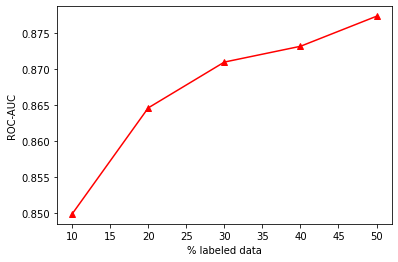

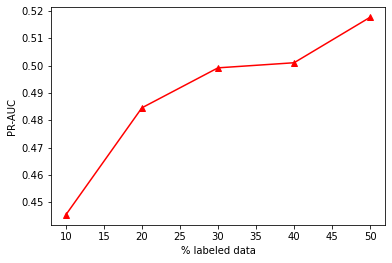

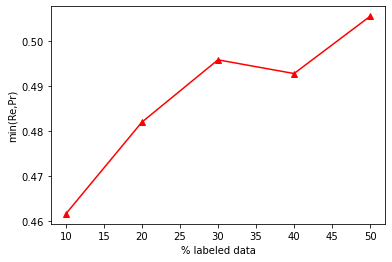

In [12]:
import matplotlib.pyplot as plt

x= range(10,51,10)
for i,metric in enumerate(['ROC-AUC', 'PR-AUC', 'min(Re,Pr)']):
    plt.figure()
    y = [gen_res[ld][i][0] for ld in x]
    plt.plot(x, y, color='r', marker='^')
    plt.xlabel('% labeled data')
    plt.ylabel(metric)
    plt.savefig(f'{metric}-mimiciv with ss random seed 2.pdf', format='pdf')

In [40]:
print("test op",test_op)
print("test ip",test_ip)
print("test ind",test_ind)

test op [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
test ip [array([[ 0.09277487,  1.14354375],
       [ 0.38677976, -0.87447463],
       [ 0.23977732, -0.87447463],
       [ 0.97478953, -0.87447463],
       [ 0.68078464,  1.14354375],
       [ 0.97478953, -0.87447463],
       [ 0.31327854, -0.87447463],
       [ 0.31327854, -0.87447463],
       [ 1.19529319,  1.14354375],
       [-1.74475565, -0.87447463],
       [-1.74475565, -0.87447463],
       [-1.59775321, -0.87447463],
       [-0.34823245,  1.14354375],
       [-0.34823245,  1.14354375],
       [ 1.37169612,  1.14354375],
       [-1.30374833, -0.87447463],
       [-1.30374833, -0.87447463],
       [-2.03876054,  1.14354375]]), array([[ 9.133333  , 10.133333  , 12.133333  , ...,  0.        ,
         0.        ,  0.        ],
       [18.383333  , 13.9       , 15.383333  , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.0833334 ,  3.5833333 ,  3.3333333 , ...,  0.        ,
         0.        ,  0.      

In [13]:
test__op_ind_df.rename(columns={'test_ind': 'ind','test_op':'op','test_predicted':'pred','test_true_op':'true'}, inplace=True)
#valid_op_ind_df.rename(columns={'valid_ind': 'ind','valid_op':'op','val_predicted':'pred','val_true_op':'true'}, inplace=True)
#roc_test = pd.concat([valid_op_ind_df, test__op_ind_df], ignore_index=True)
#len(roc_test)

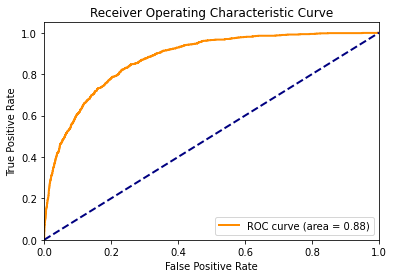

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_true and y_pred are your data
# y_true = true binary labels (either 0 or 1)
# y_pred = predicted probabilities that each entry in y_true is a 1
test_y_true = test__op_ind_df['true']
test_y_pred = test__op_ind_df['pred']
# Compute ROC curve and ROC area (AUC)
fpr, tpr, _ = roc_curve(test_y_true, test_y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.savefig(f'ROC_curve.pdf-mimiciv with ss random seed 2', format='pdf')
plt.show()


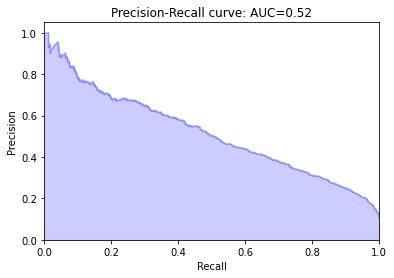

In [15]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Assuming y_true and y_pred are your data
# y_true = true binary labels (either 0 or 1)
# y_pred = predicted probabilities that each entry in y_true is a 1
test_y_true = test__op_ind_df['true']
test_y_pred = test__op_ind_df['pred']

# Compute Precision-Recall curve and the AUC-PR
precision, recall, _ = precision_recall_curve(test_y_true, test_y_pred)
average_precision = average_precision_score(test_y_true, test_y_pred)

# Plotting the Precision-Recall Curve
plt.figure()
lw = 2  # Line width
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AUC={0:0.2f}'.format(average_precision))
plt.savefig(f'PR AUC curve.pdf mimic iv with ss random seed 2', format='pdf')
plt.show()


In [16]:
test__op_ind_df.rename(columns={'ind': 'ts_ind'},inplace=True)
test__op_ind_df
#test__op_ind_df.to_csv('mimic iv final true pred with ind',index=False)

,ts_ind,op,pred,true
0,0,0.0,0.007687,0.0
1,8,0.0,0.097661,0.0
2,9,0.0,0.020064,0.0
3,14,0.0,0.794653,0.0
4,20,1.0,0.809801,1.0
...,...,...,...,...
9167,45499,0.0,0.011544,0.0
9168,45508,1.0,0.924047,1.0
9169,45548,0.0,0.004260,0.0
9170,45555,0.0,0.835929,0.0


In [17]:
data_path = 'mimic_iv_preprocessed.pkl'
data_2, oc_2, train_ind_2, valid_ind_2, test_ind_2 = pickle.load(open(data_path, 'rb'))
oc_2.sort_values(by='ts_ind')

merged_df=test__op_ind_df.merge(oc_2[['ts_ind','subject_id','hadm_id']],on='ts_ind')
merged_df

,ts_ind,op,pred,true,subject_id,hadm_id
0,0,0.0,0.007687,0.0,10002013,23581541
1,8,0.0,0.097661,0.0,10002930,25696644
2,9,0.0,0.020064,0.0,10003046,26048429
3,14,0.0,0.794653,0.0,10004235,24181354
4,20,1.0,0.809801,1.0,10004720,22081550
...,...,...,...,...,...,...
9167,45499,0.0,0.011544,0.0,19989302,21980453
9168,45508,1.0,0.924047,1.0,19990427,29695607
9169,45548,0.0,0.004260,0.0,19997752,29452285
9170,45555,0.0,0.835929,0.0,19998591,24349193


In [18]:
mimic_data_dir = '/home/anand/UHIF/UniHPF-master/UniHPF-master/mimic4/'
adm = pd.read_csv(mimic_data_dir+'admissions.csv', usecols=['subject_id','hadm_id', 'hospital_expire_flag','race'])
merged_df_eth = merged_df.merge(adm[['subject_id','hadm_id','race']],on=['subject_id','hadm_id'])
merged_df_eth

,ts_ind,op,pred,true,subject_id,hadm_id,race
0,0,0.0,0.007687,0.0,10002013,23581541,OTHER
1,8,0.0,0.097661,0.0,10002930,25696644,BLACK/AFRICAN AMERICAN
2,9,0.0,0.020064,0.0,10003046,26048429,WHITE
3,14,0.0,0.794653,0.0,10004235,24181354,BLACK/CAPE VERDEAN
4,20,1.0,0.809801,1.0,10004720,22081550,WHITE
...,...,...,...,...,...,...,...
9167,45499,0.0,0.011544,0.0,19989302,21980453,WHITE
9168,45508,1.0,0.924047,1.0,19990427,29695607,WHITE
9169,45548,0.0,0.004260,0.0,19997752,29452285,WHITE
9170,45555,0.0,0.835929,0.0,19998591,24349193,WHITE


In [19]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [20]:
# Define the mapping dictionary
racial_groupings = {
    'White': ['white', 'white - brazilian','white - eastern european', 'white - other european','white - russian','portuguese'],
    'Black': ['black/african', 'black/african american', 'black/cape verdean','black/caribbean island','south american'],
    'Hispanic/Latino': ['hispanic or latino','hispanic/latino - central american', 'hispanic/latino - columbian','hispanic/latino - cuban', 'hispanic/latino - dominican','hispanic/latino - guatemalan', 'hispanic/latino - honduran','hispanic/latino - mexican', 'hispanic/latino - puerto rican','hispanic/latino - salvadoran'],
    'Asian': ['asian', 'asian - asian indian','asian - chinese', 'asian - korean', 'asian - south east asian'],
    'Other': ['native hawaiian or other pacific islander','other','patient declined to answer', 'unable to obtain', 'unknown','american indian/alaska native','multiple race/ethnicity']
}
# Load your dataset into a pandas dataframe
#df = pd.read_csv('your_dataset.csv')
#df_admission_unique[]
# Replace the original race values with the new groupings

merged_df_eth['race'] = merged_df_eth['race'].str.strip().str.lower()
#print(df_admission_unique['race'])

def get_race_sub_group(race):
    for group, races in racial_groupings.items():
        if race in races:
            return group
    return 'Unknown'

merged_df_eth['race_sub_group'] = merged_df_eth['race'].apply(get_race_sub_group)
merged_df_eth.to_csv(f'mimic iv final_test_results with ethn and racial sub groups 50ld random seed 2.csv', index=False)

#df_admission_unique['race_sub_group'] = df_admission_unique['race'].replace(racial_groupings, regex=True)
#df_admission_unique['race_sub_group'] = df_admission_unique['race_sub_group'].map(racial_groupings)
# Check the new groupings



In [21]:
merged_df_eth.head()

,ts_ind,op,pred,true,subject_id,hadm_id,race,race_sub_group
0,0,0.0,0.007687,0.0,10002013,23581541,other,Other
1,8,0.0,0.097661,0.0,10002930,25696644,black/african american,Black
2,9,0.0,0.020064,0.0,10003046,26048429,white,White
3,14,0.0,0.794653,0.0,10004235,24181354,black/cape verdean,Black
4,20,1.0,0.809801,1.0,10004720,22081550,white,White


In [23]:
## performing the grouped fairness metrics for racial subgroups

import pandas as pd

# Assuming df contains your data
threshold = 0.5
merged_df_eth['pred_label'] = (merged_df_eth['pred'] > threshold).astype(int)

# Initialize empty dictionaries to hold calculated values for each group
demographic_parity = {}
equalized_odds_tpr = {}
equalized_odds_fpr = {}
disparate_impact = {}
false_negative_rate = {}
false_omission_rate = {}

# Loop over each demographic group to compute the metrics
for group in merged_df_eth['race_sub_group'].unique():
    sub_df = merged_df_eth[merged_df_eth['race_sub_group'] == group]
    total = len(sub_df)
    total_positives = sum(sub_df['true'] == 1)
    total_negatives = total - total_positives

    # For Demographic Parity
    demographic_parity[group] = sum(sub_df['pred_label'] == 1) / total

    # For Equalized Odds
    true_positives = sum((sub_df['true'] == 1) & (sub_df['pred_label'] == 1))
    false_positives = sum((sub_df['true'] == 0) & (sub_df['pred_label'] == 1))

    equalized_odds_tpr[group] = true_positives / total_positives if total_positives > 0 else 0
    equalized_odds_fpr[group] = false_positives / total_negatives if total_negatives > 0 else 0

    # For False Negative Rate (FNR)
    false_negatives = sum((sub_df['true'] == 1) & (sub_df['pred_label'] == 0))
    false_negative_rate[group] = false_negatives / total_positives if total_positives > 0 else 0

    # For False Omission Rate (FOR)
    false_negatives = sum((sub_df['true'] == 0) & (sub_df['pred_label'] == 0))
    false_omission_rate[group] = false_negatives / total_negatives if total_negatives > 0 else 0

# For Disparate Impact (use two groups for demonstration)
#group_a, group_b = 'WHITE', 'BLACK/AFRICAN AMERICAN'
#disparate_impact[f"{group_a}_{group_b}"] = demographic_parity[group_a] / demographic_parity[group_b] if demographic_parity[group_b] > 0 else float('inf')

#reference_group = 'White'
#for group in merged_df_eth['race_sub_group'].unique():
#    if group != reference_group:
#        key = f"{reference_group}_{group}"
#        disparate_impact[key] = demographic_parity[reference_group] / demographic_parity[group] if demographic_parity[group] > 0 else float('inf')

# Calculate Disparate Impact for all pairs of groups
for group_a in merged_df_eth['race_sub_group'].unique():
    for group_b in merged_df_eth['race_sub_group'].unique():
        if group_a != group_b:
            key = f"{group_a}_{group_b}"
            if demographic_parity[group_b] > 0:
                disparate_impact[key] = demographic_parity[group_a] / demographic_parity[group_b]
            else:
                disparate_impact[key] = float('inf')  # Handle division by zero

print(f"Demographic Parity: {demographic_parity}")
print(f"Equalized Odds (TPR): {equalized_odds_tpr}")
print(f"Equalized Odds (FPR): {equalized_odds_fpr}")
print(f"False Negative Rate: {false_negative_rate}")
print(f"False Omission Rate: {false_omission_rate}")
print(f"Disparate Impact: {disparate_impact}")

# Create DataFrames from dictionaries
demographic_parity_df = pd.DataFrame(list(demographic_parity.items()), columns=['Group', 'Demographic Parity'])
equalized_odds_tpr_df = pd.DataFrame(list(equalized_odds_tpr.items()), columns=['Group', 'Equalized Odds TPR'])
equalized_odds_fpr_df = pd.DataFrame(list(equalized_odds_fpr.items()), columns=['Group', 'Equalized Odds FPR'])
false_negative_rate_df = pd.DataFrame(list(false_negative_rate.items()), columns=['Group', 'False Negative Rate'])
false_omission_rate_df = pd.DataFrame(list(false_omission_rate.items()), columns=['Group', 'False Omission Rate'])
disparate_impact_df = pd.DataFrame(list(disparate_impact.items()), columns=['Group Pair', 'Disparate Impact'])

# Save DataFrames to different sheets in the same Excel file
with pd.ExcelWriter('fairness_metrics for race_subgroup 50ld randomseed 2.xlsx') as writer:
    demographic_parity_df.to_excel(writer, sheet_name='Demographic Parity', index=False)
    equalized_odds_tpr_df.to_excel(writer, sheet_name='Equalized Odds TPR', index=False)
    equalized_odds_fpr_df.to_excel(writer, sheet_name='Equalized Odds FPR', index=False)
    false_negative_rate_df.to_excel(writer, sheet_name='False Negative Rate', index=False)
    false_omission_rate_df.to_excel(writer, sheet_name='False Omission Rate', index=False)
    disparate_impact_df.to_excel(writer, sheet_name='Disparate Impact', index=False)


Demographic Parity: {'Other': 0.24680511182108625, 'Black': 0.18979591836734694, 'White': 0.1861124232404346, 'Asian': 0.18972332015810275, 'Hispanic/Latino': 0.19047619047619047}
Equalized Odds (TPR): {'Other': 0.7635467980295566, 'Black': 0.7216494845360825, 'White': 0.651840490797546, 'Asian': 0.6578947368421053, 'Hispanic/Latino': 0.625}
Equalized Odds (FPR): {'Other': 0.14680648236415633, 'Black': 0.13137032842582105, 'White': 0.13283032110896648, 'Asian': 0.10697674418604651, 'Hispanic/Latino': 0.14473684210526316}
False Negative Rate: {'Other': 0.23645320197044334, 'Black': 0.27835051546391754, 'White': 0.348159509202454, 'Asian': 0.34210526315789475, 'Hispanic/Latino': 0.375}
False Omission Rate: {'Other': 0.8531935176358436, 'Black': 0.8686296715741789, 'White': 0.8671696788910335, 'Asian': 0.8930232558139535, 'Hispanic/Latino': 0.8552631578947368}
Disparate Impact: {'Other_Black': 1.3003710192723898, 'Other_White': 1.3261076693534, 'Other_Asian': 1.3008686102236422, 'Other_Hi

In [24]:
merged_df_eth.head()

,ts_ind,op,pred,true,subject_id,hadm_id,race,race_sub_group,pred_label
0,0,0.0,0.007687,0.0,10002013,23581541,other,Other,0
1,8,0.0,0.097661,0.0,10002930,25696644,black/african american,Black,0
2,9,0.0,0.020064,0.0,10003046,26048429,white,White,0
3,14,0.0,0.794653,0.0,10004235,24181354,black/cape verdean,Black,1
4,20,1.0,0.809801,1.0,10004720,22081550,white,White,1


In [25]:
#Chi-Square Test for Independence: This is useful to check if the model's predictions are independent of the ethnic groups. Essentially, you'd look to see if the model is more or less likely to, say, predict ICU mortality for one group over another.

from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(merged_df_eth['race_sub_group'], merged_df_eth['pred_label'])
print("Contingency Table:")
print(contingency_table)

# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2 value: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected table:")
print(expected)







Contingency Table:
pred_label          0     1
race_sub_group             
Asian             205    48
Black             794   186
Hispanic/Latino   272    64
Other             943   309
White            5169  1182
Chi2 value: 24.853746368646966
p-value: 5.3833477599663564e-05
Degrees of freedom: 4
Expected table:
[[ 203.65231138   49.34768862]
 [ 788.85085041  191.14914959]
 [ 270.46314871   65.53685129]
 [1007.7972089   244.2027911 ]
 [5112.23648059 1238.76351941]]
